In [ ]:
!pip install fastai --upgrade
!pip install fastcore

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.0)


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 7.8MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger
from fastai.metrics import Dice, JaccardCoeff

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F


from google.colab import drive

import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import random

from fastai.vision import *
from fastai.callback.hook import *

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/"

In [ ]:
import gzip
import pickle

In [ ]:
josMod =  gzip.open(DATA_PATH+'/model_1.01.pkl','rb')

In [ ]:
josMod_model = pickle.load(josMod)

In [ ]:
path = '/content/gdrive/MyDrive/adni-data-sag_seg/'
data_path = Path(path)
# for d in os.listdir(path):
#   print(f"{d}\t{len(os.listdir(path+d))}")

In [ ]:
image_dir = "brain"
path_im = data_path/image_dir
path_lbl = data_path/"mask"

In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

In [ ]:
fnames

(#3828) [Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I75300-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I39692-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/003_S_1122-I392366-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I69587-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I96092-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I205592-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/014_S_0563-I122823-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/035_S_4582-I371240-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/035_S_4582-I291896-brain-ax3.png'),Path('/content/gdrive/MyDrive/adni-data-sag_seg/brain/035_S_4582-I340531-brain-ax3.png')...]

In [ ]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [ ]:
pix2class = n_codes(lbl_names)
pix2class

{0: 0, 1: 255}

In [ ]:
def get_msk(fn, pix2class):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = data_path/'mask'/f"{(fn.name.replace(image_dir,'mask'))}"
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(pix2class):
    msk[msk==pix2class[i]] = val
  return PILMask.create(msk)

In [ ]:
def get_y_fn(fpath):
  return get_msk(fpath, pix2class)

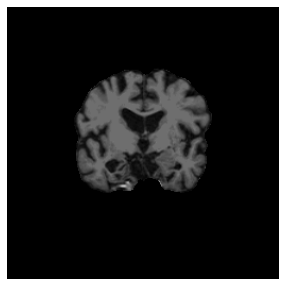

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

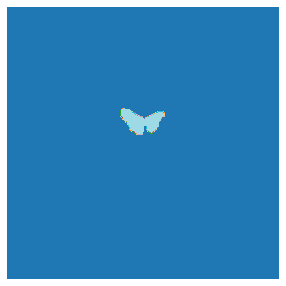

In [ ]:
msk = PILMask.create(get_y_fn(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [ ]:
def string_starts_with_1(path):
  return path.name[0] == '1'

In [ ]:
codes = ['no', 'yes']

In [ ]:
def get_n_image_files(n):
  return (lambda x: random.sample(get_image_files(x), n))

In [ ]:
brainseg_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files, #get_n_image_files(200),
    splitter=FuncSplitter(string_starts_with_1),
    get_y=get_y_fn
)

In [ ]:
dls = brainseg_block.dataloaders(path_im, bs=16)

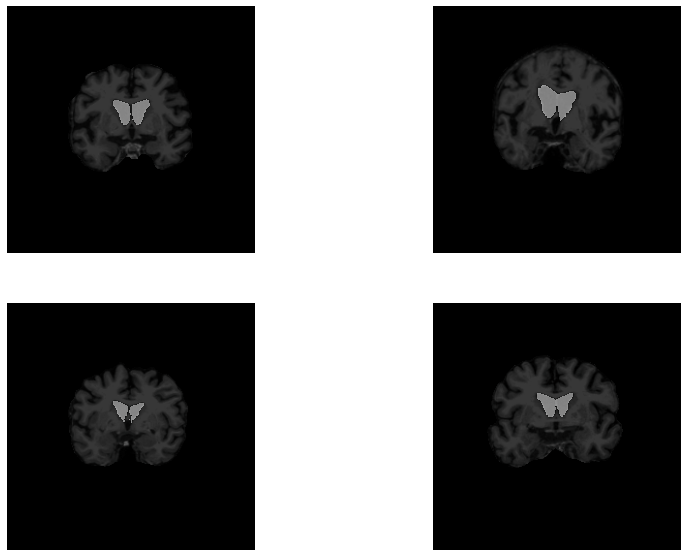

In [ ]:
dls.show_batch(max_n=4, vmin=0, vmax=1, figsize=(14,10), cmap='gray')

In [ ]:
learn = unet_learner(dls, resnet34, metrics=[Dice, JaccardCoeff], self_attention=True, act_cls=Mish)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn = load_learner('/content/gdrive/MyDrive/model_1.01.pkl','rb')

In [ ]:
learn.show_results(max_n=4, vmin=0, vmax=1, figsize=(10,20), cmap="gray")

ValueError: ignored

In [ ]:
dl = learn.dls.test_dl(fnames[:5])

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 2, 256, 256])

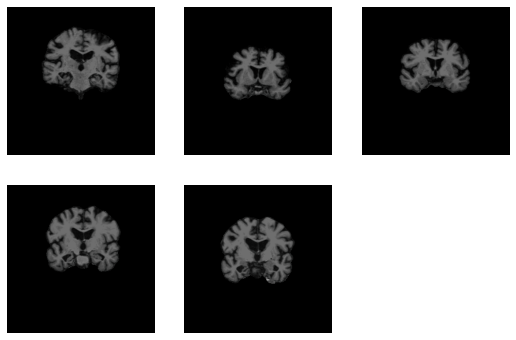

In [ ]:
dl.show_batch()

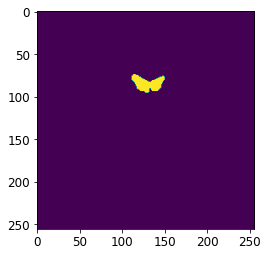

In [ ]:
pred_1 = preds[0][3]
pred_arx = pred_1.argmax(dim=0)
plt.imshow(pred_arx)

In [ ]:
!pip install voila

In [ ]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [91]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')